In [1]:
from mesh import Mesh
from parameters import kp, km, conc_rac, conc_gfp
import numpy as np
import triangle as tr
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
ACTIVE_RAC = 1e-1

In [3]:
a = 2.0
b = -(1.0 + 2.0*conc_rac*ACTIVE_RAC + km/kp)
c = conc_rac*ACTIVE_RAC
print(a, b, c)
u_b0 = (-b + math.sqrt(b**2 - 4.0*a*c))/(2.0*a)
print(u_b0)
u_0 = 1.0 - 2.0*u_b0
print(u_0)

2.0 -1.2416480978042501 0.1111111111111111
0.5124022949302405
-0.024804589860480952


In [4]:
a = 1.0
r0 = conc_rac*ACTIVE_RAC
KD = km/kp
b = KD + 2*r0 - 1.0
c = 4.0*KD
u_0 = (-b + math.sqrt(b**2 - 4.0*a*c))/(2.0*a)
print("Analytical solution for u0:", u_0)
u_b0 = 0.5*(1.0-u_0)
print("Analytical solution for ub0:", u_b0)

Analytical solution for u0: 0.6362185537202172
Analytical solution for ub0: 0.1818907231398914


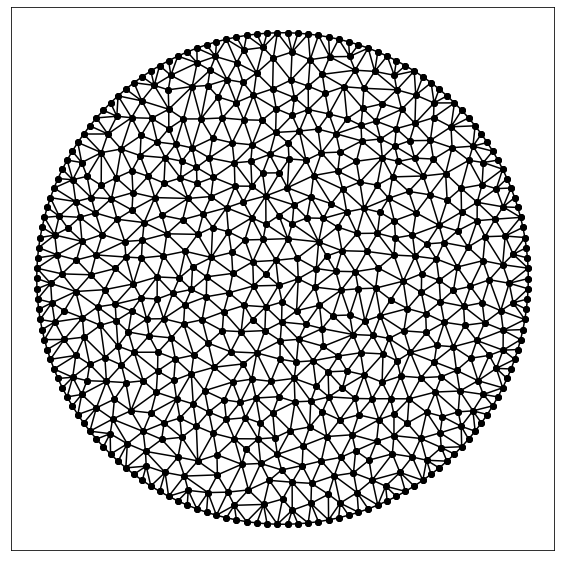

In [5]:
# Create mesh
mesh = Mesh(150, min_size=0.005, min_angle=22)

# Plot mesh
fig, axis = plt.subplots(figsize=(10,10))
tr.plot(axis, **(mesh.triangulation))
plt.show()

# Heat Equation with von Neumann Coupled Boundary

- Implicit time-stepping
- PDE: $\frac{\partial u} {\partial t} = \nabla^2 u$
- von Neumann coupled to kinetics: $\partial_n u(x,y) = -\dot{u_b}$
- Kinetic equation: $\dot{u_b} = k_+ u (r_0 - u_b) - k_- u_b$
- Initial state: $u=1$

In [6]:
class Boundary:
    def __init__(self, n_elements):
        self.n_elements = n_elements
        self.active_rac = np.zeros(n_elements)
        self.bound_gfp = np.zeros(n_elements)
        self.prev_ddt = np.zeros(n_elements)
        self.ddt = np.zeros(n_elements)
        
    def calculate_kinetic(self, index, u):
        return kp * u[index] \
            * (self.active_rac[index] - self.bound_gfp[index]) \
            - km * self.bound_gfp[index]
    
    def calculate_ddt(self, u, boundary_vertices):
        self.ddt[boundary_vertices] = \
            3.0/2.0 * np.array(list(map(
                lambda idx: self.calculate_kinetic(idx, u), \
                boundary_vertices))) \
             - 1.0/2.0 * self.prev_ddt[boundary_vertices]
        return self.ddt
    
    def update_bound(self, u, dt, boundary_vertices):
        for index in boundary_vertices:
            self.bound_gfp[index] += dt*self.ddt[index]
            self.prev_ddt[index] = self.calculate_kinetic(index, u)

Total GFP:  3.1406740296899742
Cytoplasma:  3.1406740296899742
Boundary:  0.0
Total GFP:  3.1406740296897198
Cytoplasma:  2.4594908556576938
Boundary:  0.6811831740320261
Change in total GFP: -2.544631172440859e-13
0.7831092410122901
0.1084215956299877


Text(0.5, 1.0, 'Solution')

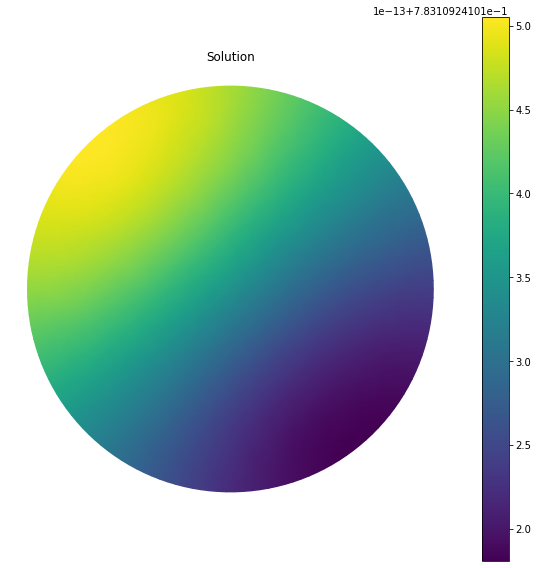

In [7]:
def calculate_initial_condition(vertex):
    return conc_gfp

def set_initial_conditions(mesh):
    return np.array(list(map(calculate_initial_condition, mesh.vertices())))

def theta_from_vertex(p):
    return np.arctan2(p[1], p[0])

def generate_boundary_values(mesh, boundary, u):
    return -1*boundary.calculate_ddt(u, mesh.boundary_vertices)

def print_integration(u, ub):
    print("Total GFP: ", mesh.integrate(u) + mesh.integrate_around_edge(boundary.bound_gfp))
    print("Cytoplasma: ", mesh.integrate(u))
    print("Boundary: ", mesh.integrate_around_edge(boundary.bound_gfp))
    
def print_change(u0, u, ub):
    total_before = mesh.integrate(u0)
    total_after = mesh.integrate(u) + mesh.integrate_around_edge(boundary.bound_gfp)
    print("Change in total GFP:", total_after - total_before)

dt = 0.01
T = 5.0
t = 0.0

# Set active Rac
boundary = Boundary(mesh.n_vertices)
for index in mesh.boundary_vertices:
    boundary.active_rac[index] = conc_rac*ACTIVE_RAC
#     theta = theta_from_vertex(mesh.get_pos(index))
#     if theta > 0:
#         boundary.active_rac[index] = conc_rac*1e-1*np.sin(theta)**2
#     else:
#         boundary.active_rac[index] = conc_rac*1.2e-1*np.sin(theta)**2


# Initial conditions
u0 = set_initial_conditions(mesh)
u_prev = set_initial_conditions(mesh)

print_integration(u0, boundary.bound_gfp)

# Assemble matrices
stiffness = mesh.assemble_stiffness()
mass = mesh.assemble_mass()
force_vector = np.zeros(mesh.n_vertices) # No reaction term within cell body

# Solve
lhs_matrix = dt*stiffness + mass

while t<T:
    boundary_values = generate_boundary_values(mesh, boundary, u_prev)
    boundary_vector = mesh.assemble_von_neumann_boundary(boundary_values)

    rhs_vector = dt*(force_vector + boundary_vector) + mass.dot(u_prev)
    u_next = np.linalg.solve(lhs_matrix, rhs_vector)
    u_prev[:] = u_next[:]
    
    boundary.update_bound(u_prev, dt, mesh.boundary_vertices)
    t+=dt

soln = u_next

print_integration(soln, boundary.bound_gfp)
print_change(u0, soln, boundary.bound_gfp)

print(soln[100])
print(boundary.bound_gfp[0])

# soln = u_next + boundary.bound_gfp

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))
mesh.plot(soln, ax)
ax.set_title('Solution')